<a href="https://colab.research.google.com/github/adityakolluru/Projects/blob/master/Language_Model_%26_Transfer_Learning_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!curl -O http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  35.9M      0  0:00:02  0:00:02 --:--:-- 35.9M


In [0]:
!tar -xvzf aclImdb_v1.tar.gz

In [0]:
PATH=Path('/content/aclImdb/')

In [0]:
CLAS_PATH=Path('/content/imdb_clas/')
CLAS_PATH.mkdir(exist_ok=True)

LM_PATH=Path('/content/imdb_lm/')
LM_PATH.mkdir(exist_ok=True)

In [0]:
from fastai.text import *

In [0]:
CLASSES = ['neg', 'pos', 'unsup']

def get_texts(path):
    texts,labels = [],[]
    for idx,label in enumerate(CLASSES):
        for fname in (path/label).glob('*.*'):
            texts.append(fname.open('r', encoding='utf-8').read())
            labels.append(idx)
    return np.array(texts),np.array(labels)

trn_texts,trn_labels = get_texts(PATH/'train')
val_texts,val_labels = get_texts(PATH/'test')

In [0]:
len(trn_texts),len(val_texts)

(75000, 25000)

In [0]:
col_names = ['labels','text']

In [0]:
np.random.seed(42)
trn_idx = np.random.permutation(len(trn_texts))
val_idx = np.random.permutation(len(val_texts))

In [0]:
trn_texts = trn_texts[trn_idx]
val_texts = val_texts[val_idx]

trn_labels = trn_labels[trn_idx]
val_labels = val_labels[val_idx]

In [0]:
df_trn = pd.DataFrame({'text':trn_texts, 'labels':trn_labels}, columns=col_names)
df_val = pd.DataFrame({'text':val_texts, 'labels':val_labels}, columns=col_names)

In [0]:
df_trn.head()

,labels,text
0,2,"""Vengo"" is a wonderfully alive feast of the fl..."
1,0,I wished I'd taped MEN IN WHITE so I could wat...
2,1,I understand that Paramount wanted to film thi...
3,2,This is a totally absurd movie with stupid fig...
4,2,This movie is a cult classic. The main reason ...


In [0]:
frames = [df_trn, df_val]

df_all = pd.concat(frames)

In [0]:
df_all.head()

,labels,text
0,2,"""Vengo"" is a wonderfully alive feast of the fl..."
1,0,I wished I'd taped MEN IN WHITE so I could wat...
2,1,I understand that Paramount wanted to film thi...
3,2,This is a totally absurd movie with stupid fig...
4,2,This movie is a cult classic. The main reason ...


In [0]:
df_all['is_valid'] = False

In [0]:
len(df_all)

100000

In [0]:
df_all.iloc[80000:, 2] = True

In [0]:
df_all.groupby('labels').size()

labels
0    25000
1    25000
2    50000
dtype: int64

In [0]:
df_all['labels'].replace([0,1,2], ['positive', 'negative', 'unsupervised'], inplace = True)

In [0]:
df_all.head()

,labels,text,is_valid
0,unsupervised,"""Vengo"" is a wonderfully alive feast of the fl...",False
1,positive,I wished I'd taped MEN IN WHITE so I could wat...,False
2,negative,I understand that Paramount wanted to film thi...,False
3,unsupervised,This is a totally absurd movie with stupid fig...,False
4,unsupervised,This movie is a cult classic. The main reason ...,False


In [0]:
df_all['text'][1]

1    I wished I'd taped MEN IN WHITE so I could wat...
1    In "Hoot", a new kid arrives to Florida from M...
Name: text, dtype: object

In [0]:
df_all.to_csv(PATH/'texts.csv')

In [0]:
data_lm = TextDataBunch.from_csv(PATH, 'texts.csv', text_cols='text', label_cols='labels', valid_pct=0.2)

In [0]:
data_lm.save('tmp_lm')


In [0]:
data_lm = TextLMDataBunch.load(PATH, 'tmp_lm', bs=bs)
data_lm.show_batch()


idx,text
0,"cocaine - sniffing mother wannabe , xxmaj don xxmaj cheadle as a black man struggling with identity as pornstar / stereo - salesman in some wild xxunk and xxmaj william xxup h. xxmaj macy , who 's wife is the ultimate slut . xxmaj not to mention a nearly unrecognizable xxmaj alfred xxmaj molina . xxmaj macy 's new year 's eve bash and xxmaj cheadle 's chance for a"
1,"dance to the xxmaj republican party ( "" xxmaj family "" ) ? \n\n xxmaj or xxmaj sally xxmaj kellerman warbling lovingly to xxmaj george xxmaj kennedy , doing her best xxmaj cher impression as she hops from one rock to another ( "" xxmaj every xxmaj little xxmaj thing xxmaj you xxmaj do "" ) ? xxmaj and my favourite , xxmaj bobby xxmaj van embodying the strength of"
2,"where it faults immediately , is that there is no future . xxmaj nobody cares about consequences or decisions , and there is no authority there to stop them . xxmaj sure , this was 1965 , the times had fewer boundaries , but xxmaj wilson does n't give us this . xxmaj she allows her girls to have free reign and control , and thus the story becomes disastrous"
3,"xxmaj shawshank to be somewhat cliche and extremely manipulative ( for creating loveable prisoners and for that sappy closing monologue ) . xxmaj do n't get me wrong ... i think xxmaj shawshank is very well done , but it has become overrated , and this is exactly what it needed . xxbos xxmaj the 1980s xxup tv show , updated with fresh female flesh , and raunchy language ."
4,"pretty girls into unattainable goddesses . \n\n i 'll have to admit , the show is a guilty pleasure . xxmaj maybe it 's the state of mind i 'm in , but i kept wondering where the xxunk was in cases when the already thin girls would need to hurl to make the cut and look the way the judges and photographers and many fickle designers would feel was"


In [0]:
learn = language_model_learner(data_lm, pretrained_model=URLs.WT103_1, drop_mult=0.3)

language modeling involves predicting the next word in a sequence, when given a sequence of words as an input. A major reason why RNNs are slow is that each word in that input string must be processed sequentially: in the sentence “Parallelization is fun”, the words ‘parallelization’ and ‘is’ must be processed before the word ‘fun’.

In [0]:
learn.lr_find()


epoch,train_loss,valid_loss,accuracy


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


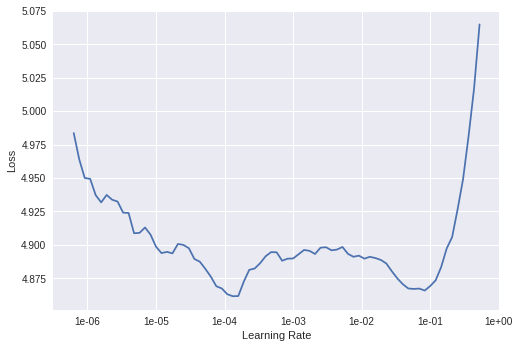

In [0]:
learn.recorder.plot(skip_end=15)

In [0]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,4.366298,4.195803,0.286379


In [0]:
learn.save('fit_head')
  

In [0]:
learn.load('fit_head');


In [0]:
learn.unfreeze()

In [0]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))


NameError: ignored